In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image

In [8]:
# Define the root directories for training and testing
train_dir = 'C:/Users/Patrik/Desktop/Files/fei/Ing/2nd class/HNS/project/Dataset_Znacky/Train-adj-train-test/train'
test_dir = 'C:/Users/Patrik/Desktop/Files/fei/Ing/2nd class/HNS/project/Dataset_Znacky/Train-adj-train-test/test'
num_classes = len(os.listdir(train_dir))

# Define transforms for data augmentation and normalization
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create custom datasets for training and testing
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load the pre-trained AlexNet model
model = models.mobilenet_v2(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False
    
# Update the output layer to match the number of classes in your dataset
num_classes = 12  # Replace with the actual number of classes in your dataset
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
#num_features = model.classifier[6].in_features
#model.classifier[6] = nn.Linear(num_features, num_classes)

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Epoch [1/20], Step [0/755], Loss: 0.8927
Epoch [1/20], Step [100/755], Loss: 0.8319
Epoch [1/20], Step [200/755], Loss: 0.9612
Epoch [1/20], Step [300/755], Loss: 0.5128
Epoch [1/20], Step [400/755], Loss: 0.8096
Epoch [1/20], Step [500/755], Loss: 0.7178
Epoch [1/20], Step [600/755], Loss: 0.4190
Epoch [1/20], Step [700/755], Loss: 0.7401
Epoch [1/20], Average Training Loss: 0.7846
Epoch [1/20], Average Validation Loss: 0.8576
Epoch [2/20], Step [0/755], Loss: 0.7087
Epoch [2/20], Step [100/755], Loss: 0.4920
Epoch [2/20], Step [200/755], Loss: 0.5357
Epoch [2/20], Step [300/755], Loss: 0.7630
Epoch [2/20], Step [400/755], Loss: 0.8507
Epoch [2/20], Step [500/755], Loss: 0.7030
Epoch [2/20], Step [600/755], Loss: 0.4089
Epoch [2/20], Step [700/755], Loss: 0.4849
Epoch [2/20], Average Training Loss: 0.7671
Epoch [2/20], Average Validation Loss: 0.8235
Epoch [3/20], Step [0/755], Loss: 0.9445
Epoch [3/20], Step [100/755], Loss: 0.8662
Epoch [3/20], Step [200/755], Loss: 0.5926
Epoch [3/

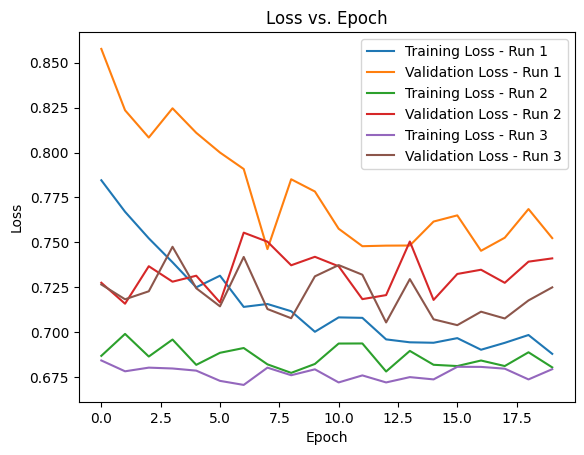

Average Test Accuracy over 3 runs: 73.35%


In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()  
num_epochs = 20
accumulated_test_accuracies = []
num_classes = 12  


for run in range(3):  
    model.to(device)
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)
    
    train_loss_values = []
    val_loss_values = []

    for epoch in range(num_epochs):
        
        model.train()
        epoch_train_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            epoch_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:  
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

            torch.cuda.empty_cache()
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_loss_values.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {avg_train_loss:.4f}')

      
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (data, targets) in enumerate(test_loader): 
                data, targets = data.to(device), targets.to(device)

                outputs = model(data)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()
        avg_val_loss = epoch_val_loss / len(test_loader)
        val_loss_values.append(avg_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Validation Loss: {avg_val_loss:.4f}')

    plt.plot(train_loss_values, label=f"Training Loss - Run {run+1}")
    plt.plot(val_loss_values, label=f"Validation Loss - Run {run+1}")

    print("Training complete.")
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0

  
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

          
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

       
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    accumulated_test_accuracies.append(test_accuracy)

    print(f"Run {run+1} Test Accuracy: {test_accuracy:.2f}%")


average_accuracy = sum(accumulated_test_accuracies) / 3

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()
print(f"Average Test Accuracy over 3 runs: {average_accuracy:.2f}%")

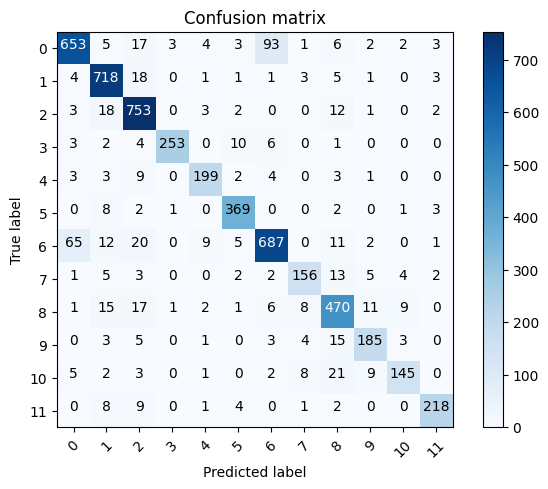

In [17]:
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(int(cm[i, j]), 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
confusion_matrix = np.zeros((num_classes, num_classes))
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = outputs.max(1)
        for t, p in zip(targets.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

plot_confusion_matrix(confusion_matrix, list(range(num_classes)))